In [1]:
import skimage
from skimage import measure
import matplotlib.pyplot as plt
from skimage import data, io, color
from skimage.filters import threshold_li
from skimage.filters import try_all_threshold
from skimage.color import rgb2hsv
import numpy as np
from matplotlib import path
from matplotlib.path import Path
import matplotlib.patches as patches
import math

In [2]:
# Function to apply a Value filter to input image
# Input: Path to image
# Output: image converted to 2-dimensional array, with Value reduced to 0, Hue and Saturation unchanged
def hsv_value_filter(imgpath):
    rgb_img = skimage.io.imread(imgpath)
    hsv_img = rgb2hsv(rgb_img)
    value_img = hsv_img[:, :, 2]
    return value_img


# Function to find contour line from grayscale image
# Input: Grayscale image (2-dimensional array with values from 0-1)
# output: Contour line
def tail_contour_li_threshold_grayscale_input(tail_img_gray):
    #tail_img_gray = color.rgb2gray(tail_img)  
    mask_threshold = threshold_li(tail_img_gray)
    tail_img_mask = tail_img_gray < mask_threshold
    
    # Improvement 13.1: Add left - right borders 3 pixels each
    tail_img_mask[:,0:5] = 0
    tail_img_mask[:,-6:-1] = 0
    
    contours = measure.find_contours(tail_img_mask, 0.9) 
    # Find the largest contour in the list of contours
    contours.sort(key=len,reverse=True)
    largest_contour = contours[0]
    
    # Improvement 13.2: Compare the largest (1) vs 2nd-largest (2) contour
    # If no_of_points(2) and area(2) are >= 0.5 those of (1), 
    # then there's a high chance that it's a picture with notch point under water
    # In that case draw a line to join 2 flukes & find contour again
    if(len(contours) > 1):
        c1 = contours[0] # largest
        c2 = contours[1] # 2nd largest

        no_of_points_ratio = len(c2)/len(c1)
        area_ratio = PolyArea(c2[:, 1],c2[:, 0])/PolyArea(c1[:, 1],c1[:, 0])
        
        # we expect the two flukes to cover ~ the same area, otherwise it's most likely just a random area of water
        if (no_of_points_ratio >= 0.5 and area_ratio >=0.5): 
            p1, p2 = closest_pair(c1,c2)
            # Visualize the 2 closest points on img mask
            #print('Visualizing the two closest points')
            #fig = plt.figure(figsize=(24,9))
            #plt.imshow(tail_img_mask, cmap='gray')
            #plt.plot(p1[1],p1[0], marker='o', markersize=10, color="blue")
            #plt.plot(p2[1],p2[0], marker='o', markersize=10, color="red")

            # draw a L-connector of 6 pixels between 2 contours
            draw_L_shape(tail_img_mask,p1,p2,6)

            # Find contours again on the jont contour
            contours = measure.find_contours(tail_img_mask, 0.9) 
            # Find the largest contour in the list of contours
            contours.sort(key=len,reverse=True)
            #largest_contour = contours[0]

            largest_contour = contours[0]
            #c2 = contours[1]
            #c3 = contours[2]
            
    return largest_contour

# https://stackoverflow.com/questions/34372480/rotate-point-about-another-point-in-degrees-python
# Function to rotate a set of points around an origin by a predefined degrees
# Input: set of points, for example a contour line; origin of rotation; rotation angle in degree
# Output: the same set of points rotated
def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

# Function to extract edge line from a given contour. 
# Edge line is tilted so that the straight line connecting left-right tips is parallel with x axis
# Input: contour line
# Ourput: edge line, tilted horizontally
def extract_edge_tilt(contour):
    # Move contour to line towards root (0,0)
    contour[:,0] -= contour[:,0].min()
    contour[:,1] -= contour[:,1].min()

    # Get middle y point of contour line
    middle_y = (contour[:,0].max() - contour[:,0].min())/2

    # FIND NOTCH POINT
    # Get 25% and 75% on x as left and right boundaries to find notch point
    left_bound = contour[:,1].max() * 0.25
    right_bound = contour[:,1].max() * 0.75

    # Cut the area containing notch point by middle_y, left and right boundaries
    c_notch = contour[ (contour[:,0] < middle_y) & (contour[:,1] > left_bound) & (contour[:,1] < right_bound)]

    # If there is no point in the notch area => bad contour line, stops finding edge & returns bottom half of the contour image
    if (len(c_notch) == 0):
        return contour[(contour[:,0] < middle_y)]

    # Find notch points == points that have the highest y in the notch area
    c_notch_y = c_notch[:,0].max()
    c_notch_points = c_notch[c_notch[:,0] == c_notch_y]

    notch_point = c_notch_points[0]

    # FIND LEFT-RIGHT TIPS OF THE FLUKE
    # Cut the bottom half of the tail
    c_bottom = contour[ (contour[:,0] < middle_y)]
    # Find the left tip
    left_tip_x = c_bottom[:,1].min()
    left_tips = c_bottom[c_bottom[:,1] == left_tip_x]
    left_tip = left_tips[0] # if there are several points at min_x
    # Find the right tip
    right_tip_x = c_bottom[:,1].max()
    right_tips = c_bottom[c_bottom[:,1] == right_tip_x]
    right_tip = right_tips[-1] # if there are several points at max_x
    
    # CREATE A PATH OBJECT THAT BOUNDS THE FLUKE
    # The path is limited by 5 points: bottom_left,left_tip, notch_point, right_tip,bottom_right
    bottom_left = np.array([0,left_tip[1]])
    bottom_right = np.array([0,right_tip[1]])
    verts = [bottom_left,left_tip, notch_point, right_tip,bottom_right,bottom_left]
    codes = [
        Path.MOVETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.LINETO,
        Path.CLOSEPOLY,
    ]
    edge_path = Path(verts, codes)
    
    # Extract the edge from bottom half of the image using the path as a mask
    c_edge = c_bottom[edge_path.contains_points(c_bottom)]
    
    # Identify the tilt angle
    diff = right_tip - left_tip
    tilt_angle = np.rad2deg(math.atan(diff[0]/diff[1]))
    
    # Identify rotate center - midpoint of left and right tips
    rotate_center = ((left_tip[0]+right_tip[0])/2,(left_tip[1]+right_tip[1])/2)
        
    # Rotate the edge to balance horizontally around the rotate center
    c_edge_tilted = rotate(c_edge, origin=rotate_center, degrees=tilt_angle)
    return c_edge_tilted

# function to identify the corner point of the L shape connecting two given points 
# L shape is drawn given that the horizontal edge must be below the vertical edge. i.e ┕ and ┙ =>ok, ┍ and ┑ => not ok
def find_corner_point (point1, point2):
    (x1, y1) = point1
    (x2, y2) = point2
    y = min(y1,y2)
    if(y == y1):
        x = x2
    else: 
        x = x1
    return (x,y)

# Function to draw a L shape in a given black-white image (2d array)
# between 2 given points
def draw_L_shape(img, point1, point2, width):
    (x1, y1) = point1
    (x2, y2) = point2
    (xc, yc) = find_corner_point(point1, point2)
    half_width = int(width/2)
    # Draw the horizontal line:
    if(x1<x2):
        img[x1-half_width:x2+half_width,yc-half_width:yc+half_width] = 1
    else:
        img[x2-half_width:x1+half_width,yc-half_width:yc+half_width] = 1
    # Draw vertical line
    if(y1<y2):
        img[xc-half_width:xc+half_width,y1-half_width:y2+half_width] = 1
    else:
        img[xc-half_width:xc+half_width,y2-half_width:y1+half_width] = 1

# function to find one point in a curve that is closest to a given point
def closest_node(node, nodes):
    dist = np.sum((nodes - node)**2, axis=1)
    closest_index = np.argmin(dist)
    return nodes[closest_index], dist[closest_index]

# function to find one point in a curve that is closest to a given point
# return values is converted to int because later are used as matrix indexes
def closest_pair(c1,c2):
    min_point_c2 = c2[0]
    min_point_c1, min_dist = closest_node(c2[0], c1)
    for point in c2:
        p, d = closest_node(point, c1)
        if d < min_dist:
            min_point_c2 = point
            min_point_c1 = p
            min_dist = d
    return min_point_c1.astype(int), min_point_c2.astype(int)

# function to calculate area limited by a polygon
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

# Visualize all edge extraction steps

../data/train/1645/PM-WWA-20060518-011.jpg
no_of_points_ratio: 0.7803075694028361 ; area_ratio: 0.12091243252297064


ValueError: zero-size array to reduction operation maximum which has no identity

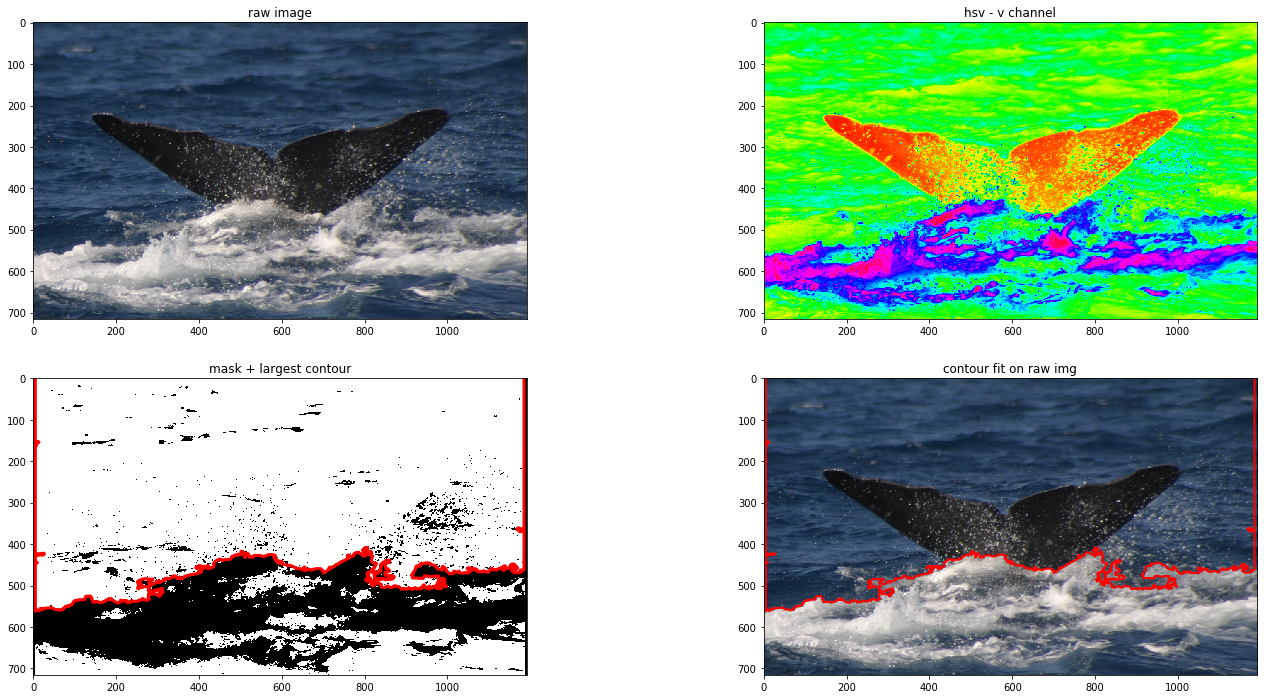

In [11]:
# UPDATE: up to 13.2 (L-shape connector)

#img_path = '../experiments/rotate/tail+10.jpg'
#img_path = '../data/test_val/PM-WWA-20170414-359.jpg'
#img_path = '../data/train/1250/PM-WWA-20110820-051.jpg'
#img_path = '../data/test_val/PM-WWA-20170321-322.jpg'
##img_path = '../data/test_val/PM-WWA-20170321-344.jpg'
#img_path = '../data/test_val/PM-WWA-20170321-053.jpg'
##img_path = '../data/test_val/PM-WWA-20170430-010.jpg'

#img_path = '../data/train/5453/PM-WWA-20140313-037.jpg'
#img_path = '../data/test_val/PM-WWA-20180407-414.jpg'
#img_path = '../data/test_val/PM-WWA-20180805-023.jpg'
#img_path = '../data/train/5817/PM-WWA-20160417-085.jpg'
img_path = '../data/train/1645/PM-WWA-20060518-011.jpg'

print(img_path)
fig,axes = plt.subplots(2, 2, figsize=(24,12))

rgb_img= io.imread(img_path)
axes[0, 0].set_title('raw image')
axes[0, 0].imshow(rgb_img, interpolation='nearest'); 

# HSV FILTER
hsv_img = rgb2hsv(rgb_img)
value_img = hsv_img[:, :, 2]
#fig = plt.figure()
axes[0, 1].set_title('hsv - v channel')
axes[0, 1].imshow(value_img, cmap='hsv')


# CONTOUR EXTRACTION

mask_threshold = threshold_li(value_img)
tail_img_mask = value_img < mask_threshold


# Improvement 13.1: Add left - right borders 3 pixels each
tail_img_mask[:,0:5] = 0
tail_img_mask[:,-6:-1] = 0

contours = measure.find_contours(tail_img_mask, 0.9) 
# Find the largest contour in the list of contours
contours.sort(key=len,reverse=True)
largest_contour = contours[0]

# Improvement 13.2: Compare the largest (1) vs 2nd-largest (2) contour
# If no_of_points(2) and area(2) are >= 0.5 those of (1), 
# then there's a high chance that it's a picture with notch point under water
# In that case draw a line to join 2 flukes & find contour again
if(len(contours) > 1):
    c1 = contours[0] # largest
    c2 = contours[1] # 2nd largest

    no_of_points_ratio = len(c2)/len(c1)
    area_ratio = PolyArea(c2[:, 1],c2[:, 0])/PolyArea(c1[:, 1],c1[:, 0])
    print('no_of_points_ratio: {} ; area_ratio: {}'.format(no_of_points_ratio,area_ratio))

    # we expect the two flukes to cover ~ the same area, otherwise it's most likely just a random area of water
    if (no_of_points_ratio >= 0.5 and area_ratio >=0.5): 
        p1, p2 = closest_pair(c1,c2)
        # Visualize the 2 closest points on img mask
        #print('Visualizing the two closest points')
        #fig = plt.figure(figsize=(24,9))
        #plt.imshow(tail_img_mask, cmap='gray')
        #plt.plot(p1[1],p1[0], marker='o', markersize=10, color="blue")
        #plt.plot(p2[1],p2[0], marker='o', markersize=10, color="red")

        # draw a L-connector of 6 pixels between 2 contours
        draw_L_shape(tail_img_mask,p1,p2,6)

        # Find contours again on the jont contour
        contours = measure.find_contours(tail_img_mask, 0.9) 
        # Find the largest contour in the list of contours
        contours.sort(key=len,reverse=True)
        #largest_contour = contours[0]

        largest_contour = contours[0]
        #c2 = contours[1]
        #c3 = contours[2]

#fig = plt.figure()
axes[1, 0].set_title('mask + largest contour')
axes[1, 0].imshow(tail_img_mask, cmap='gray')
axes[1, 0].plot(largest_contour[:, 1], largest_contour[:, 0],  linewidth=3, color = 'red') 

#fig = plt.figure()
axes[1, 1].set_title('contour fit on raw img')
axes[1, 1].imshow(rgb_img, interpolation='nearest'); 
axes[1, 1].plot(largest_contour[:, 1], largest_contour[:, 0],  linewidth=2, color = 'red') 

contour = largest_contour
# Move contour to line towards root (0,0)
contour[:,0] -= contour[:,0].min()
contour[:,1] -= contour[:,1].min()

# Get middle y point of contour line
middle_y = (contour[:,0].max() - contour[:,0].min())/2

# FIND NOTCH POINT
# Get 25% and 75% on x as left and right boundaries to find notch point
left_bound = contour[:,1].max() * 0.25
right_bound = contour[:,1].max() * 0.75

# Cut the area containing notch point by middle_y, left and right boundaries
c_notch = contour[ (contour[:,0] < middle_y) & (contour[:,1] > left_bound) & (contour[:,1] < right_bound)]

# If there is no point in the notch area => bad contour line, returns empty (can't find notch point)
if (len(c_notch) == 0):
    notch_point = []

# Find notch points == points that have the highest y in the notch area
c_notch_y = c_notch[:,0].max()
c_notch_points = c_notch[c_notch[:,0] == c_notch_y]

notch_point = c_notch_points[0]

# FIND LEFT-RIGHT TIPS OF THE FLUKE
# Cut the bottom half of the tail
c_bottom = contour[ (contour[:,0] < middle_y)]
# Find the left tip
left_tip_x = c_bottom[:,1].min()
left_tips = c_bottom[c_bottom[:,1] == left_tip_x]
left_tip = left_tips[0] # if there are several points at min_x
# Find the right tip
right_tip_x = c_bottom[:,1].max()
right_tips = c_bottom[c_bottom[:,1] == right_tip_x]
right_tip = right_tips[-1] # if there are several points at max_x
fig = plt.figure(figsize=(8,3)) 
#plt.gca().invert_yaxis() # set cordinate root (0,0) to top left point
plt.plot(notch_point[1], notch_point[0], marker='o', markersize=10, color="red")
plt.plot(left_tip[1], left_tip[0], marker='o', markersize=10, color="red")
plt.plot(right_tip[1], right_tip[0], marker='o', markersize=10, color="red")
plt.plot(contour[:, 1], contour[:, 0],  linewidth=2, color = 'black')  
bottom_left = np.array([0,left_tip[1]])
bottom_right = np.array([0,right_tip[1]])
verts = [bottom_left,left_tip, notch_point, right_tip,bottom_right,bottom_left]
codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,
]
path = Path(verts, codes)

fig, ax = plt.subplots(figsize = [3,6])
patch = patches.PathPatch(path, facecolor='orange', lw=2)
ax.add_patch(patch)
ax.set_xlim(0, notch_point[0]*3)
ax.set_ylim(0, right_tip[1])
ax.plot(contour[:, 0], contour[:, 1],  linewidth=2, color = 'black')  
plt.show()
c_edge = c_bottom[path.contains_points(c_bottom)]
fig = plt.figure(figsize=(8,3)) 
#plt.gca().invert_yaxis() # set cordinate root (0,0) to top left point
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(notch_point[1], notch_point[0], marker='o', markersize=10, color="red")
plt.plot(left_tip[1], left_tip[0], marker='o', markersize=10, color="red")
plt.plot(right_tip[1], right_tip[0], marker='o', markersize=10, color="red")
plt.plot(c_edge[:, 1], c_edge[:, 0],  linewidth=2, color = 'black')  
diff = right_tip - left_tip
tilt_angle = np.rad2deg(math.atan(diff[0]/diff[1]))
r_img = rotate(c_edge, origin=left_tip, degrees=tilt_angle)
fig = plt.figure(figsize=(8,3)) 
plt.gca().set_aspect('equal', adjustable='box')
#plt.gca().invert_yaxis() # set cordinate root (0,0) to top left point
plt.plot(c_edge[:, 1], c_edge[:, 0],  linewidth=3, color = 'red')  
#plt.plot((rotate_center[0],points[0][0]), (rotate_center[1],points[0][1]),  linewidth=1, color = 'red')
#plt.plot((rotate_center[0],points[1][0]), (rotate_center[1],points[1][1]),  linewidth=1, color = 'red')
plt.plot(r_img[:, 1], r_img[:, 0],  linewidth=3, color = 'blue')  
#plt.plot((rotate_center[0],new_points[0][0]), (rotate_center[1],new_points[0][1]),  linewidth=1, color = 'blue')
#plt.plot((rotate_center[0],new_points[1][0]), (rotate_center[1],new_points[1][1]),  linewidth=1, color = 'blue')
plt.plot(left_tip[1], left_tip[0], marker='o', markersize=10, color="green")
fig = plt.figure(figsize=(8,3)) 
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(r_img[:, 1], r_img[:, 0],  linewidth=2, color = 'black')  

## Issue 1: contour is not a closed curve

In [102]:
# Example 
img_path = '../data/test_val/PM-WWA-20170321-344.jpg'

#img_path = '../data/test_val/PM-WWA-20170705-011.jpg'
#img_path = '../data/train/3483/PM-WWA-20071209-005.jpg'

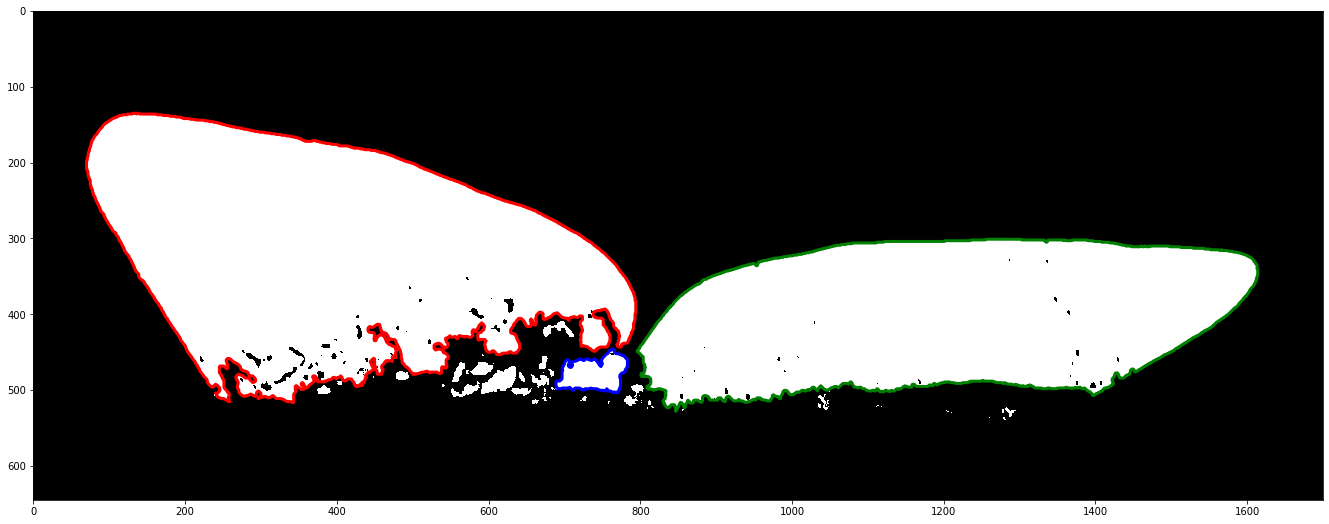

In [6]:
rgb_img= io.imread(img_path)
hsv_img = rgb2hsv(rgb_img)
value_img = hsv_img[:, :, 2]
#fig = plt.figure()
#axes[0, 1].set_title('hsv - v channel')
#axes[0, 1].imshow(value_img, cmap='hsv')

mask_threshold = threshold_li(value_img)
tail_img_mask = value_img < mask_threshold
contours = measure.find_contours(tail_img_mask, 0.9) 
# Find the largest contour in the list of contours
contours.sort(key=len,reverse=True)
#largest_contour = contours[0]
fig = plt.figure(figsize=(24,9))
plt.imshow(tail_img_mask, cmap='gray')

c1 = contours[0]
c2 = contours[1]
c3 = contours[2]
plt.plot(c1[:, 1], c1[:, 0],  linewidth=3, color = 'red') 
plt.plot(c2[:, 1], c2[:, 0],  linewidth=3, color = 'green') 
plt.plot(c3[:, 1], c3[:, 0],  linewidth=3, color = 'blue') 

In [104]:
print(len(c1),len(c2),len(c3))

6499 4522 2037


Solution: Draw left-right borders of 5 pixels each to prevent open contours

In [105]:
# draw a black left-right borders of 5 pixels each
tail_img_mask[:,0:5] = 0
tail_img_mask[:,-6:-1] = 0

In [106]:
tail_img_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

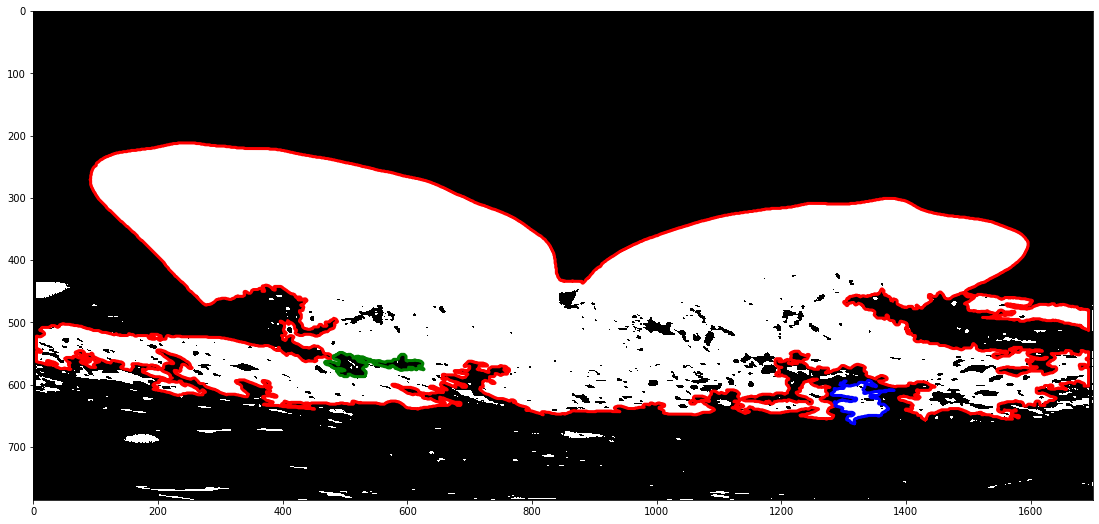

In [107]:
contours = measure.find_contours(tail_img_mask, 0.9) 
# Find the largest contour in the list of contours
contours.sort(key=len,reverse=True)
#largest_contour = contours[0]
fig = plt.figure(figsize=(24,9))
plt.imshow(tail_img_mask, cmap='gray')

c1 = contours[0]
c2 = contours[1]
c3 = contours[2]
plt.plot(c1[:, 1], c1[:, 0],  linewidth=3, color = 'red') 
plt.plot(c2[:, 1], c2[:, 0],  linewidth=3, color = 'green') 
plt.plot(c3[:, 1], c3[:, 0],  linewidth=3, color = 'blue') 

In [100]:
print(len(c1),len(c2),len(c3))

21853 6566 3387


## Issue 2: Notch point under water

### Example

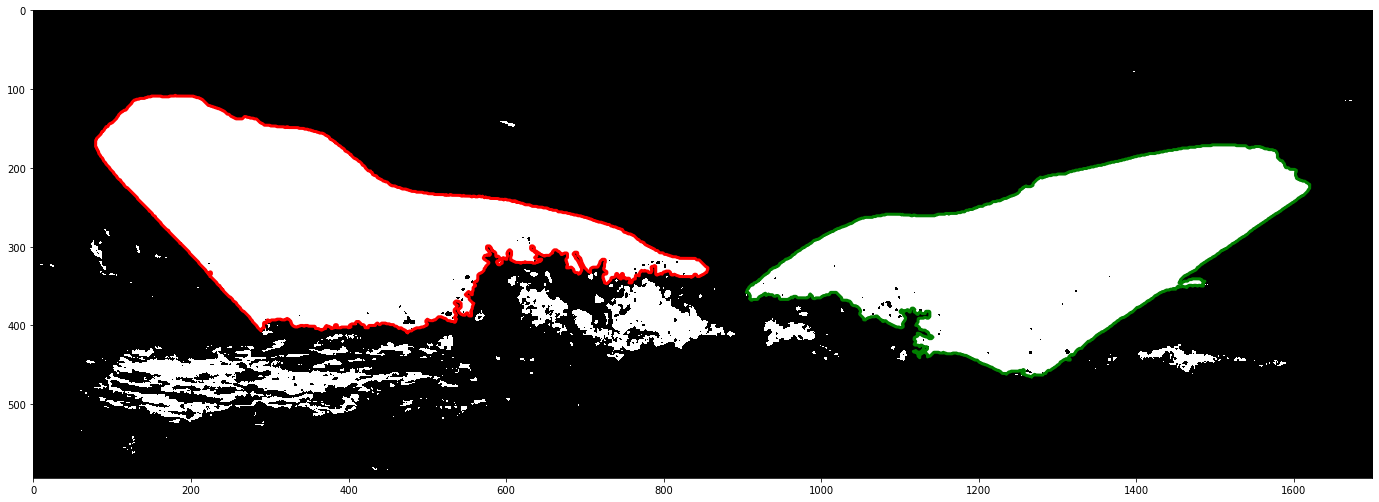

In [4]:
# Examples
#img_path = '../data/test_val/PM-WWA-20180917-311.jpg'
#img_path = '../data/test_val/PM-WWA-20170510-814.jpg'
#img_path = '../data/test_val/PM-WWA-20170511-629.jpg'
#img_path = '../data/test_val/PM-WWA-20170602-1018.jpg'
#img_path = '../data/test_val/PM-WWA-20170605-259.jpg'
#img_path = '../data/test_val/PM-WWA-20170612-183.jpg'
#img_path = '../data/test_val/PM-WWA-20170623-276.jpg'

img_path = '../data/test_val/PM-WWA-20180627-143.jpg'

# these examples has len(contour_max1) ~ len(contour_max2)
#but contour_max2 is actually an area of water that have the same color, not part of the fluke
#img_path = '../data/test_val/PM-WWA-20170622-037.jpg' 
#img_path = '../data/test_val/PM-WWA-20170607-088.jpg'

rgb_img= io.imread(img_path)
hsv_img = rgb2hsv(rgb_img)
value_img = hsv_img[:, :, 2]
#fig = plt.figure()
#axes[0, 1].set_title('hsv - v channel')
#axes[0, 1].imshow(value_img, cmap='hsv')

mask_threshold = threshold_li(value_img)
tail_img_mask = value_img < mask_threshold
contours = measure.find_contours(tail_img_mask, 0.9) 
# Find the largest contour in the list of contours
contours.sort(key=len,reverse=True)
#largest_contour = contours[0]
fig = plt.figure(figsize=(24,9))
plt.imshow(tail_img_mask, cmap='gray')

c1 = contours[0]
c2 = contours[1]
#c3 = contours[2]
plt.plot(c1[:, 1], c1[:, 0],  linewidth=3, color = 'red') 
plt.plot(c2[:, 1], c2[:, 0],  linewidth=3, color = 'green') 
#plt.plot(c3[:, 1], c3[:, 0],  linewidth=3, color = 'blue') 

Solution: Find the two closest points between the 2 largest contours, draw a white (L) line between them

### Function to draw an L-shape connector between 2 points

In [5]:
# function to identify the corner point of the L shape connecting two given points 
# L shape is drawn given that the horizontal edge must be below the vertical edge. i.e ┕ and ┙ =>ok, ┍ and ┑ => not ok
def find_corner_point (point1, point2):
    (x1, y1) = point1
    (x2, y2) = point2
    y = min(y1,y2)
    if(y == y1):
        x = x2
    else: 
        x = x1
    return (x,y)

# Function to draw a L shape in a given black-white image (2d array)
# between 2 given points
def draw_L_shape(img, point1, point2, width):
    (x1, y1) = point1
    (x2, y2) = point2
    (xc, yc) = find_corner_point(point1, point2)
    half_width = int(width/2)
    print(half_width)
    print(x1,x2,yc-half_width,yc+half_width)
    # Draw the horizontal line:
    if(x1<x2):
        img[x1-half_width:x2+half_width,yc-half_width:yc+half_width] = 1
    else:
        img[x2-half_width:x1+half_width,yc-half_width:yc+half_width] = 1
    # Draw vertical line
    if(y1<y2):
        img[xc-half_width:xc+half_width,y1-half_width:y2+half_width] = 1
    else:
        img[xc-half_width:xc+half_width,y2-half_width:y1+half_width] = 1

In [6]:
p1 = (10,50)
p2 = (70,30)
p3 = find_corner_point(p1,p2)

3
10 70 27 33


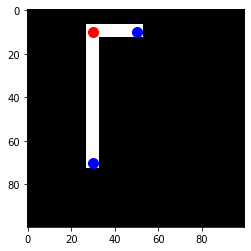

In [7]:
black_img = np.zeros((100,100))
#black_img[30:40,30] = 1
draw_L_shape(black_img,p1,p2,6)
fig = plt.figure()
plt.imshow(black_img, cmap='gray')
plt.plot(p1[1],p1[0], marker='o', markersize=10, color="blue")
plt.plot(p2[1],p2[0], marker='o', markersize=10, color="blue")
plt.plot(p3[1],p3[0], marker='o', markersize=10, color="red")

### Function to find pair of points with shortest distance in 2 contours

In [8]:
# function to find one point in a curve that is closest to a given point
def closest_node(node, nodes):
    dist = np.sum((nodes - node)**2, axis=1)
    closest_index = np.argmin(dist)
    return nodes[closest_index], dist[closest_index]

# function to find one point in a curve that is closest to a given point
# return values is converted to int because later are used as matrix indexes
def closest_pair(c1,c2):
    min_point_c2 = c2[0]
    min_point_c1, min_dist = closest_node(c2[0], c1)
    for point in c2:
        p, d = closest_node(point, c1)
        if d < min_dist:
            min_point_c2 = point
            min_point_c1 = p
            min_dist = d
    return min_point_c1.astype(int), min_point_c2.astype(int)

### Function to calculate area limited by a polygon
See Experiment 4, section 2

In [9]:
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

### Apply functions to largest & 2nd-largest contours

0.8480672268907563
103881.01999986172
106276.41999998689
0.9774606634272639
Visualizing the two closest points
3
332 355 852 858


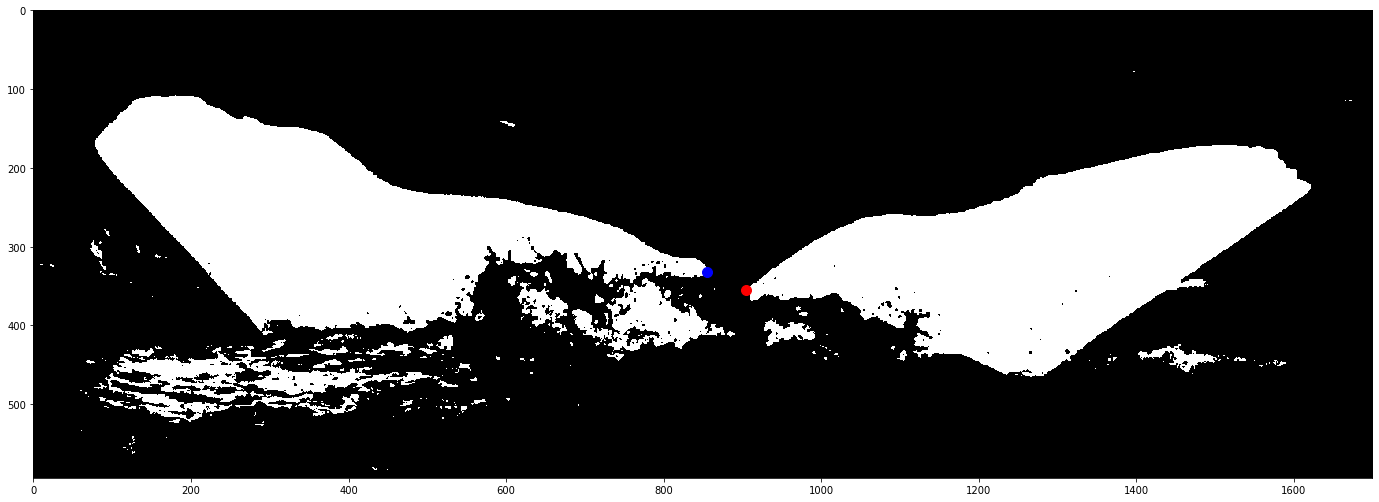

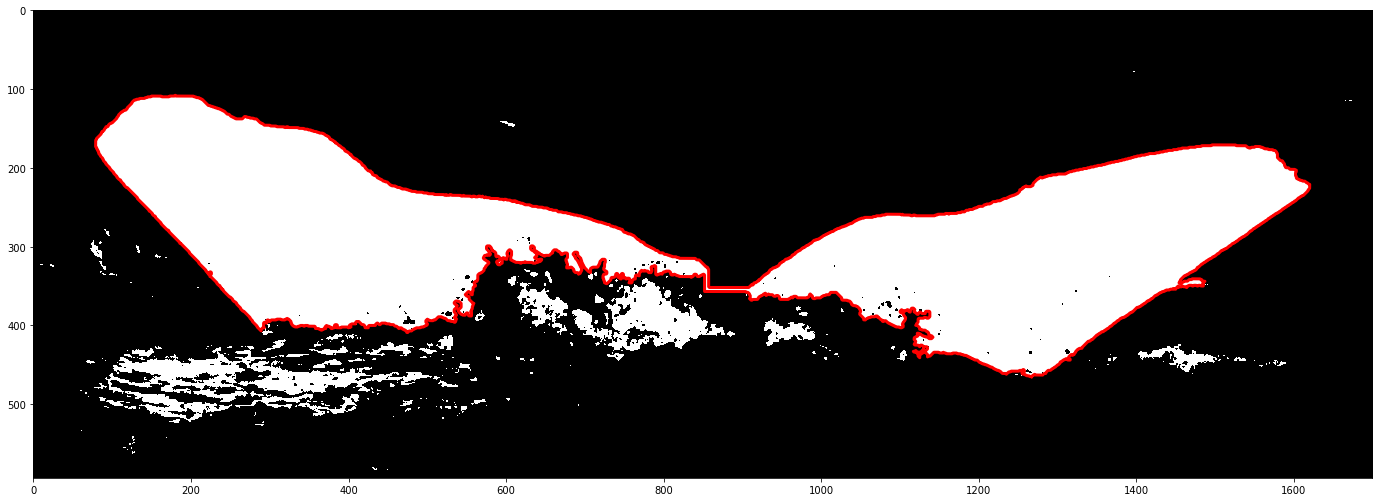

In [10]:
mask_threshold = threshold_li(value_img)
tail_img_mask = value_img < mask_threshold
contours = measure.find_contours(tail_img_mask, 0.9) 
# Find the 2 largest contours in the list of contours
contours.sort(key=len,reverse=True)
c1 = contours[0] # largest
c2 = contours[1] # 2nd largest

print(len(c2)/len(c1))
print(PolyArea(c2[:, 1],c2[:, 0]))
print(PolyArea(c1[:, 1],c1[:, 0]))
print(PolyArea(c2[:, 1],c2[:, 0])/PolyArea(c1[:, 1],c1[:, 0]))

no_of_points_ratio = len(c2)/len(c1)
area_ratio = PolyArea(c2[:, 1],c2[:, 0])/PolyArea(c1[:, 1],c1[:, 0])
# we expect the two flukes to cover ~ the same area
# otherwise it's most likely just an area of water
if (no_of_points_ratio >= 0.5 and area_ratio >=0.5): 
    p1, p2 = closest_pair(c1,c2)
    # Visualize the 2 closest points on img mask
    print('Visualizing the two closest points')
    fig = plt.figure(figsize=(24,9))
    plt.imshow(tail_img_mask, cmap='gray')
    plt.plot(p1[1],p1[0], marker='o', markersize=10, color="blue")
    plt.plot(p2[1],p2[0], marker='o', markersize=10, color="red")
    
    # draw a L-connector of 6 pixels between 2 contours
    draw_L_shape(tail_img_mask,p1,p2,6)
    
    # Find contours again on the jont contour
    contours = measure.find_contours(tail_img_mask, 0.9) 
    # Find the largest contour in the list of contours
    contours.sort(key=len,reverse=True)
    #largest_contour = contours[0]
    
    c1 = contours[0]
    #c2 = contours[1]
    #c3 = contours[2]
   
else: 
    print('2nd largest contour is not part of the fluke')
    
fig = plt.figure(figsize=(24,9))
plt.imshow(tail_img_mask, cmap='gray')
plt.plot(c1[:, 1], c1[:, 0],  linewidth=3, color = 'red') 

# Tuning contour recognition

## How many imgs with 2 largest contours not too different (size)?

In [ ]:
import os
testval_path = "../data/test_val/"

In [ ]:
# Redefine tail_contour_li_threshold_grayscale_input, now returning all contours for test purpose
def tail_contours(tail_img_gray):
    #tail_img_gray = color.rgb2gray(tail_img)  
    mask_threshold = threshold_li(tail_img_gray)
    tail_img_mask = tail_img_gray < mask_threshold
    contours = measure.find_contours(tail_img_mask, 0.9) 
    # Find the largest contour in the list of contours
    contours.sort(key=len,reverse=True)
    #largest_contour = contours[0]
    return contours

Let's see how many images in TEST_VAL folder that have **size(2nd largest contour) >= 50% * size(largest contour)**

In [ ]:
import os
testval_path = "../data/test_val/"
#testval_contour_path = "../experiments/12. contour_edge_Li_tilt_noscaling_hsv-filter/test-val/"

images = os.listdir(testval_path)

img_count = len(images)
i = 0

c0c1_ratios = {}
for img in images:
    in_file = testval_path + img
    tail_img_filtered = hsv_value_filter(in_file)
    contours = tail_contours(tail_img_filtered)
    if(len(contours) == 1):
        c0c1_ratios[img] = 0.0001
    else:
        c0 = contours[0]
        c1 = contours[1]
        c0c1_ratios[img] = len(c1)/len(c0)
        #print(len(c0),len(c1))
        
    #progress tracking
    i += 1
    if (i%10 == 0):
        print("processed {}/{} images ({}%)".format(i,img_count,round(i/img_count*100,2)))

In [ ]:
ratio_list_test = list(c0c1_ratios.values())

In [ ]:
possibly_wrong_ratios_test = [i for i in ratio_list_test if i >= 0.5]

In [ ]:
print(len(possibly_wrong_ratios_test),len(ratio_list_test),len(possibly_wrong_ratios_test)/len(ratio_list_test))

137/808 images in test_val. How about in train?

In [ ]:
train_path = "../data/train/"

subfolders = os.listdir(train_path)

train_file_count = 4539 - 577 # We know in advance the number of training images, in whih 577 images belong to class -1
i=0

c0c1_ratios_train = {}
for sf in subfolders:
    #Skip folder -1 
    if (sf == '-1'):
        continue 
    
    # Get list of images in each subfolder
    images = os.listdir(train_path + sf)
    # Find contour for each image & calculate ratios
    for img in images:
        in_file = train_path + sf + "/" + img
        tail_img_filtered = hsv_value_filter(in_file)
        contours = tail_contours(tail_img_filtered)
        if(len(contours) == 1):
            c0c1_ratios_train[img] = 0.0001 
        else:
            c0 = contours[0]
            c1 = contours[1]
            c0c1_ratios_train[img] = len(c1)/len(c0)
            #print(len(c0),len(c1))
        #progress tracking
        i += 1
        if (i%10 == 0):
            print("processed {}/{} images ({}%)".format(i,train_file_count,round(i/train_file_count*100,2)))

In [ ]:
ration_list_train = list(c0c1_ratios_train.values())
possibly_wrong_ratios_train = [i for i in ration_list_train if i >= 0.5]

In [ ]:
print(len(possibly_wrong_ratios_train),len(ration_list_train),len(possibly_wrong_ratios_train)/len(ration_list_train))

In [ ]:
test_ratios_1 = c0c1_ratios.copy()
train_ratios_1 = c0c1_ratios_train.copy()

Ok, 436/3962 (11%) images in train that possibly have wrong largest contour

## Improvement 1: Add left - right borders

In [ ]:
# Redefine tail_contour_li_threshold_grayscale_input, now returning all contours for test purpose
# Now before finding threshold, we'll add left - right vertical borders, width = 5 pixels each
def tail_contours(tail_img_gray):
    #tail_img_gray = color.rgb2gray(tail_img)  
    mask_threshold = threshold_li(tail_img_gray)
    tail_img_mask = tail_img_gray < mask_threshold
    
    # Add left - right borders
    tail_img_mask[:,0:5] = 0
    tail_img_mask[:,-6:-1] = 0
    
    contours = measure.find_contours(tail_img_mask, 0.9) 
    # Find the largest contour in the list of contours
    contours.sort(key=len,reverse=True)
    #largest_contour = contours[0]
    return contours

Let'ls apply this on train - test set and re-assess the ratio

In [ ]:
import os
testval_path = "../data/test_val/"
#testval_contour_path = "../experiments/12. contour_edge_Li_tilt_noscaling_hsv-filter/test-val/"

images = os.listdir(testval_path)

img_count = len(images)
i = 0

c0c1_ratios = {}
for img in images:
    in_file = testval_path + img
    try:
        tail_img_filtered = hsv_value_filter(in_file)
        contours = tail_contours(tail_img_filtered)
        if(len(contours) == 1):
            c0c1_ratios[img] = 0.0001
        else:
            c0 = contours[0]
            c1 = contours[1]
            c0c1_ratios[img] = len(c1)/len(c0)
            #print(len(c0),len(c1))
    except:
        print(in_file)
        
    #progress tracking
    i += 1
    if (i%10 == 0):
        print("processed {}/{} images ({}%)".format(i,img_count,round(i/img_count*100,2)))

In [ ]:
print(in_file)

In [ ]:
ratio_list_test = list(c0c1_ratios.values())
possibly_wrong_ratios_test = [i for i in ratio_list_test if i >= 0.5]
print(len(possibly_wrong_ratios_test),len(ratio_list_test),len(possibly_wrong_ratios_test)/len(ratio_list_test))

In [ ]:
train_path = "../data/train/"

subfolders = os.listdir(train_path)

train_file_count = 4539 - 577 # We know in advance the number of training images, in whih 577 images belong to class -1
i=0

c0c1_ratios_train = {}
for sf in subfolders:
    #Skip folder -1 
    if (sf == '-1'):
        continue 
    
    # Get list of images in each subfolder
    images = os.listdir(train_path + sf)
    # Find contour for each image & calculate ratios
    for img in images:
        in_file = train_path + sf + "/" + img
        try:
            tail_img_filtered = hsv_value_filter(in_file)
            contours = tail_contours(tail_img_filtered)
            if(len(contours) == 1):
                c0c1_ratios_train[img] = 0.0001
            else:
                c0 = contours[0]
                c1 = contours[1]
                c0c1_ratios_train[img] = len(c1)/len(c0)
                #print(len(c0),len(c1))
        except:
            print(in_file)
            
        #progress tracking
        i += 1
        if (i%10 == 0):
            print("processed {}/{} images ({}%)".format(i,train_file_count,round(i/train_file_count*100,2)))

In [ ]:
ration_list_train = list(c0c1_ratios_train.values())
possibly_wrong_ratios_train = [i for i in ration_list_train if i >= 0.5]
print(len(possibly_wrong_ratios_train),len(ration_list_train),len(possibly_wrong_ratios_train)/len(ration_list_train))

In [ ]:
test_ratios_2 = c0c1_ratios.copy()
train_ratios_2 = c0c1_ratios_train.copy()

### Compare with before adding vertical borders

In [ ]:
test_imgs_before = test_ratios_1.keys()
test_imgs_after = test_ratios_2.keys()
train_imgs_before = train_ratios_1.keys()
train_imgs_after = train_ratios_1.keys()

In [ ]:
# subset test example
list_a = [9, 4, 5, 8, 10] 
list_b = [10, 5] 
list_c = [4, 8, 13] 
print(set(list_b).issubset(set(list_a)))
print(set(list_c).issubset(set(list_a)))

In [ ]:
def filter_dict(d): # Filter keys in a dictionary having value > 0.5
    imgs = []
    for k in d.keys():
        if d[k] >= 0.5:
            imgs.append(k)
    return imgs

In [ ]:
possibly_wrong_ratios_test_before = filter_dict(test_ratios_1)
possibly_wrong_ratios_train_before = filter_dict(train_ratios_1)
possibly_wrong_ratios_test_after = filter_dict(test_ratios_2)
possibly_wrong_ratios_train_after = filter_dict(train_ratios_2)

In [ ]:
print(len(possibly_wrong_ratios_test_before))
print(len(possibly_wrong_ratios_train_before))
print(len(possibly_wrong_ratios_test_after))
print(len(possibly_wrong_ratios_train_after))

In [ ]:
print(set(possibly_wrong_ratios_test_after).issubset(set(possibly_wrong_ratios_test_before)))
print(set(possibly_wrong_ratios_train_after).issubset(set(possibly_wrong_ratios_train_before)))

Both False => adding left-right borders solves some images, but create contour problem in other images.  
Now exporting images to Excel to compare. See "Compare.xlsx" in Exp13 folder

In [ ]:
def print_filter_dict(d): # Print keys in a dictionary having value > 0.5
    for k in d.keys():
        if d[k] >= 0.5:
            print(k,',',d[k])

In [ ]:
print_filter_dict(test_ratios_1)

In [ ]:
print_filter_dict(test_ratios_2)

In [ ]:
print_filter_dict(train_ratios_1)

In [ ]:
print_filter_dict(train_ratios_2)

Compare result:
After adding border, the contour issue of (max2/max1 > 0.5) is detected in the following images:
- Test_val
    - PM-WWA-20170611-060.jpg
    - PM-WWA-20171009-074.jpg
    - PM-WWA-20180725-013.jpg
- Train
    - PM-WWA-20050416-027.jpg
    - PM-WWA-20050714-094.jpg
    - PM-WWA-20050723-244.jpg
    - PM-WWA-20060612-009.jpg
    - PM-WWA-20060612-098.jpg
    - PM-WWA-20060611-032.jpg
    - PM-WWA-20090903-115.jpg
    - PM-WWA-20060615-A119.jpg
    - PM-WWA-20060829-002.jpg
    - PM-WWA-20070515-001.jpg
    - PM-WWA-20120605-009.jpg
    - PM-WWA-20130724-335.jpg
    - PM-WWA-20140313-037.jpg

Among these 16 images:
- 9 images have bad quality (border or no border doesn't make a different anyway)
- 5 images - threshold Li failed (same - doesn't matter with border or not)
- 1 image - hsv doens't work
- 1 image - largest contour still the correct one  

So, it's safe to say that adding left-right borders doesn't introduce any problem

### Conclusion
Considering cut-off ratio = 50% between largest and second largest contours, adding left - right borders improves edge extraction on (137-101) + (436-338) ~ 134 images  
Still have ~ 439 images to go

### Regenerate edge images after adding borders

See notebook "[Experiment 13.1] - Adding borders to img mask"

## Improvement 2: join left-right flukes of cases where notch point under water

See notebook  "[Experiment 13.2] - Notch point under water